In [3]:
import pandas as pd
import numpy as np
import csv
import re
import datetime
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


good_data, bad_data = [], []

def is_missing(x):
    return x is None or x.strip() == "" or pd.isna(x)

with open("US_Crime_Data.csv", mode="r", encoding="utf-8") as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  

    for row in csv_reader:
        if not row or len(row) < 8:
            bad_data.append(row)
            continue

        date, title, organization, city, state, url, keyword, summary = row

        bad = False

        # check for empty or missing
        if any(is_missing(x) for x in row[:8]):
            bad = True
        else:
            # validate date
            date_val = pd.to_datetime(date, errors='coerce')
            if pd.isna(date_val):
                bad = True

        if len(state.strip()) != 2:
            bad = True

        if bad:
            bad_data.append(row)
        else:
            good_data.append(row)

columns = ["date","title","organization","city","state","url","keyword","summary"]

good_df = pd.DataFrame(good_data, columns=columns)
bad_df = pd.DataFrame(bad_data, columns=columns)

good_df.to_csv("good_data.csv", index=False)
bad_df.to_csv("bad_data.csv", index=False)

## [Question 4]: What is the distribution of hate-crime reporting during the peak month?

*** Data Overview ***:
Total articles: 3118
Date range: 2017-08-01 to 2017-08-31
States covered: 58
Years in dataset: [np.int32(2017)] (1 years)

💡 STRATEGIC RECOMMENDATION:
   Focus awareness campaigns in the second and third weeks of August during peak reporting periods

🎯 DATA QUALITY NOTE: 3118 articles analyzed from 1 year(s)


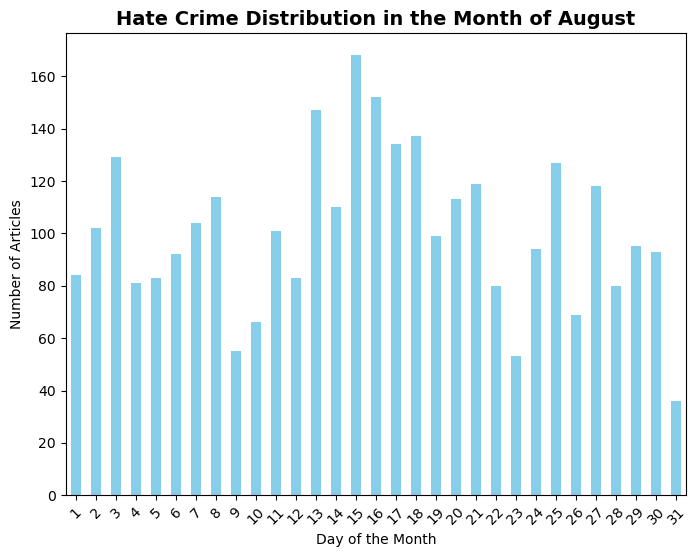

In [4]:
#[Question 4]: What is the distribution of hate-crime reporting during the peak month?
columns = ["date","title","organization","city","state","url","keyword","summary"]
good_df = pd.DataFrame(good_data, columns=columns)

# Convert and clean dates
good_df['date'] = pd.to_datetime(good_df['date'], format='mixed', errors='coerce')
good_df = good_df.dropna(subset=['date'])

# Select dates for peak month (August 1st to August 31st)
start_date = '2017-08-01'
end_date = '2017-08-31'

print(f"*** Data Overview ***:")
print(f"Total articles: {len(good_df)}")
print(f"Date range: {start_date} to {end_date}")
print(f"States covered: {good_df['state'].nunique()}")

# Extract  features
good_df['year'] = good_df['date'].dt.year
good_df['day'] = good_df['date'].dt.day
good_df['year_month'] = good_df['date'].dt.to_period('M')

years = sorted(good_df['year'].unique())
print(f"Years in dataset: {years} ({len(years)} years)")

# Create the graph visualization
plt.figure(figsize=(8, 6))
plt.title('Hate Crime Distribution in the Month of August', fontsize=14, fontweight='bold')

daily_counts = good_df['day'].value_counts().sort_index()

daily_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Articles')
plt.tick_params(axis='x', rotation=45)

# Strategic recommendations
print(f"\n💡 STRATEGIC RECOMMENDATION:")
print(f"   Focus awareness campaigns in the second and third weeks of August during peak reporting periods")
print(f"\n🎯 DATA QUALITY NOTE: {len(good_df)} articles analyzed from {len(years)} year(s)")

[Question5]: Can we predict how many cities in each state will report hate crimes based off of how many cities report hate crimes each month?

C:\Users\Wilde\AppData\Local\Temp\ipykernel_26784\2996443366.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  good_df['date'] = pd.to_datetime(good_df['date'], errors='coerce')


Model Results:
-------------------------
Mean Absolute Error: 2.053
R² Score: -0.109


C:\Users\Wilde\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


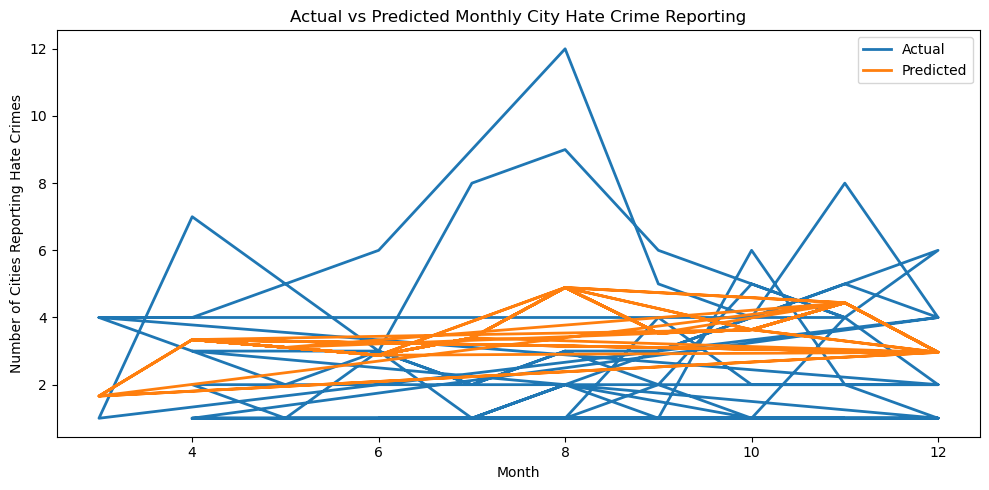


Predicted number of cities reporting next month (all states combined model): 2.96


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

columns = ["date","title","organization","city","state","url","keyword","summary"]
good_df = pd.DataFrame(good_data, columns=columns)

# Convert date column
good_df['date'] = pd.to_datetime(good_df['date'], errors='coerce')

# Extract month and year
good_df['year'] = good_df['date'].dt.year
good_df['month'] = good_df['date'].dt.month

# Count unique cities reporting hate crimes per state per month
monthly_state_counts = (
    good_df.groupby(['state', 'year', 'month'])['city']
      .nunique()
      .reset_index()
      .rename(columns={'city': 'num_cities_reporting'})
)

# Create a numeric date index for modeling
monthly_state_counts['date_index'] = (
    (monthly_state_counts['year'] - monthly_state_counts['year'].min()) * 12
    + monthly_state_counts['month']
)

# --- MODELING ---

# Features and target
X = monthly_state_counts[['date_index']]
y = monthly_state_counts['num_cities_reporting']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Results:")
print("-------------------------")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

# Example: Predict number of cities next month for each state
future = monthly_state_counts.copy()
future_month = future['date_index'].max() + 1

future_pred = model.predict([[future_month]])

plt.figure(figsize=(10, 5))

plt.plot(
    X_test['date_index'],
    y_test,
    label='Actual',
    linewidth=2
)

plt.plot(
    X_test['date_index'],
    y_pred,
    label='Predicted',
    linewidth=2
)

plt.xlabel("Month")
plt.ylabel("Number of Cities Reporting Hate Crimes")
plt.title("Actual vs Predicted Monthly City Hate Crime Reporting")
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nPredicted number of cities reporting next month (all states combined model): {future_pred[0]:.2f}")

[Question6]: Is there a correlation between the number of cities reporting hate crimes in a state and the frequency of hate-crime–related news articles from that state?

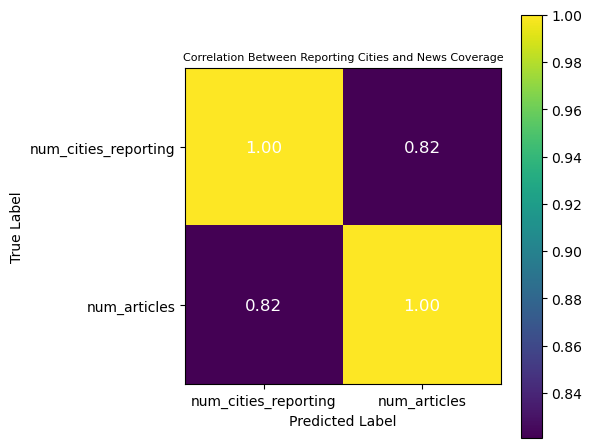

In [6]:
good_df['date'] = pd.to_datetime(good_df['date'], errors='coerce')
good_df['year'] = good_df['date'].dt.year
good_df['month'] = good_df['date'].dt.month

# -----------------------------
# COUNT CITIES REPORTING
# -----------------------------
city_counts = (
    good_df.groupby(['state', 'year', 'month'])['city']
      .nunique()
      .reset_index()
      .rename(columns={'city': 'num_cities_reporting'})
)

# -----------------------------
# COUNT NEWS ARTICLES
# -----------------------------
article_counts = (
    good_df.groupby(['state', 'year', 'month'])
      .size()
      .reset_index(name='num_articles')
)

# -----------------------------
# MERGE FOR CORRELATION
# -----------------------------
merged = pd.merge(
    city_counts,
    article_counts,
    on=['state', 'year', 'month'],
    how='inner'
)

# -----------------------------
# CORRELATION MATRIX
# -----------------------------
corr_matrix = merged[['num_cities_reporting', 'num_articles']].corr()

# -----------------------------
# HEATMAP WITH LABELS
# -----------------------------
plt.figure(figsize=(6,5))
heatmap = plt.imshow(corr_matrix, aspect='equal')

# Title
plt.title("Correlation Between Reporting Cities and News Coverage", fontsize=8)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Axis labels
plt.xticks(
    range(len(corr_matrix.columns)),
    corr_matrix.columns,
    fontsize=10
)
plt.yticks(
    range(len(corr_matrix.columns)),
    corr_matrix.columns,
    fontsize=10
)

# Colorbar
plt.colorbar(heatmap)

# Annotate correlation values on heatmap
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        plt.text(
            j, i,
            f"{corr_matrix.iloc[i, j]:.2f}",
            ha='center',
            va='center',
            color='white',
            fontsize=12
        )

plt.tight_layout()
plt.show()

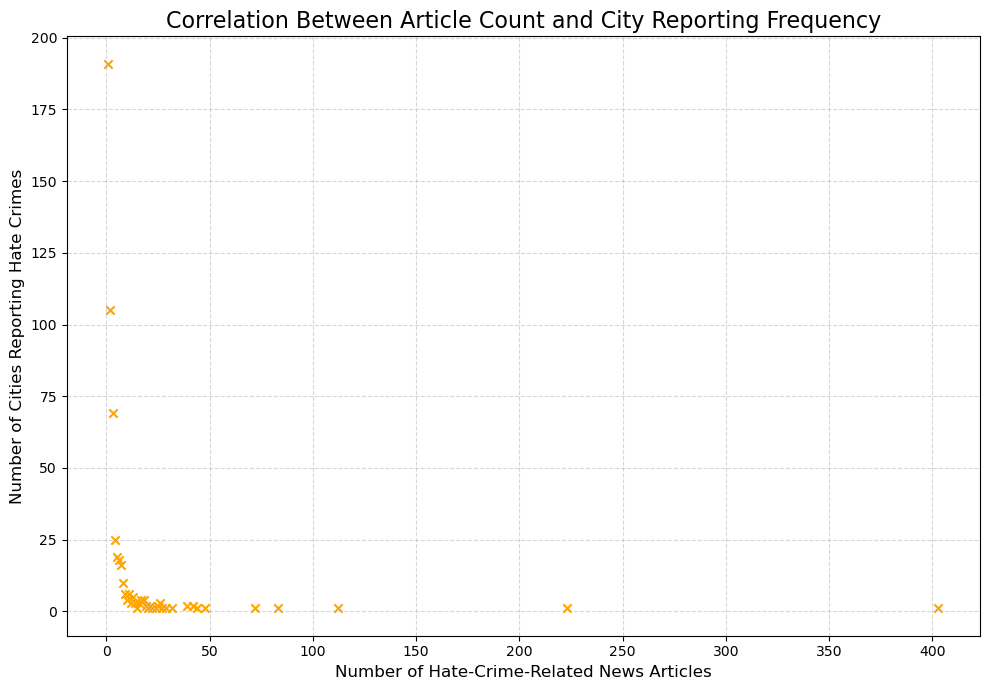

In [8]:
# Count number of articles for each city
article_counts_by_city = good_df['city'].value_counts()

# Prepare x = number of articles, y = number of cities with that number
data = article_counts_by_city.value_counts().sort_index()

x_vals = data.index            # number of articles
y_vals = data.values           # number of cities

# Create scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(x_vals, y_vals, color='orange', marker='x')

plt.title("Correlation Between Article Count and City Reporting Frequency", fontsize=16)
plt.xlabel("Number of Hate-Crime-Related News Articles", fontsize=12)
plt.ylabel("Number of Cities Reporting Hate Crimes", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()